## environment: Kaggle TPU v5-e8

In [1]:
!pip uninstall tensorflow tensorflow-cpu jax jaxlib -y
!pip install tensorflow==2.18.0 -q
!pip install tensorflow-tpu==2.18.0 --find-links=https://storage.googleapis.com/libtpu-tf-releases/index.html -q

Found existing installation: tensorflow 2.20.0
Uninstalling tensorflow-2.20.0:
  Successfully uninstalled tensorflow-2.20.0
Found existing installation: tensorflow_cpu 2.20.0
Uninstalling tensorflow_cpu-2.20.0:
  Successfully uninstalled tensorflow_cpu-2.20.0
Found existing installation: jax 0.8.0
Uninstalling jax-0.8.0:
  Successfully uninstalled jax-0.8.0
Found existing installation: jaxlib 0.8.0
Uninstalling jaxlib-0.8.0:
  Successfully uninstalled jaxlib-0.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distrax 0.1.7 requires jax>=0.7.0, which is not installed.
distrax 0.1.7 requires jaxlib>=0.7.0, which is not installed.
jraph 0.0.6.dev0 requires jax>=0.1.55, which is not installed.
jraph 0.0.6.dev0 requires jaxlib>=0.1.37, which is not installed.
orbax-checkpoint 0.11.27 requires jax>=0.6.0, which is not installed.
optax 0.2.6 requires jax>=0.5.3, whi

In [ ]:
import tensorflow as tf
print(" Initializing TPU Strategy ")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    strategy = tf.distribute.get_strategy()
    print("STRATEGY: ", strategy)
    

print(tf.__version__)

E0000 00:00:1765216573.430245      12 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


 Initializing TPU Strategy 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1765216589.234021      12 service.cc:148] XLA service 0x5c555fab4480 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765216589.234050      12 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1765216589.234053      12 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1765216589.234057      12 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1765216589.234058      12 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1765216589.234059      12 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1765216589.234061      12 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1765216589.234062      12 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1765216589.234064      12 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
!pip install faiss-cpu --quiet
import faiss 
from sklearn.metrics import classification_report

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
# config
OUTPUT_DIR = Path("./stutvec11")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 1024
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 64
EPOCHS = 50
LEARNING_RATE = 2e-5
THRESHOLD = 0.3

K_NEIGHBORS = 5
FAISS_INDEX_PATH = OUTPUT_DIR / "train_data.index"

TRAIN_DATA_PATH = "/kaggle/input/w2v-prc-large/output_wav2vec_custom_augmented/train_data.npz"
VAL_DATA_PATH = "/kaggle/input/w2v-prc-large-val/output_wav2vec_custom_augmented/val_data.npz"
TEST_DATA_PATH = "/kaggle/input/w2v-prc-large-test/output_wav2vec_custom_augmented/test_data.npz"
BEST_MODEL_PATH = OUTPUT_DIR / "model_stfold.keras"
EMBEDDER_WEIGHTS_PATH = Path(OUTPUT_DIR / "embedder.weights.h5")

BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
print(f"Global batch size set to: {BATCH_SIZE}")

Global batch size set to: 64


In [ ]:
# dat loading
print("\nLoading all compressed features")
train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

X_train, y_train_full = train_data['x'], train_data['y']
X_val, y_val_full = val_data['x'], val_data['y']
X_test, y_test_full = test_data['x'], test_data['y']

# remv NoStutter
y_train = y_train_full[:, :-1]
y_val = y_val_full[:, :-1]
y_test = y_test_full[:, :-1]
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and filtered successfully.")
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


 Loading all compressed features 


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from scipy.spatial.distance import pdist, squareform
import numpy as np

# embedder
def build_base_embedder(input_shape):
    """
    BiGRU-based embedder with Attention Pooling.
    train and save to use later
    """
    sequence_input = layers.Input(shape=input_shape, name="sequence_input")
    # BiGRU Encoder
    x = layers.Bidirectional(layers.GRU(256, return_sequences=True))(sequence_input)
    x = layers.Dense(1024, activation='relu')(x)   
    # attn pooling head
    scores = layers.Dense(1, activation='tanh', name='attention_scores')(x)
    attention_weights = layers.Softmax(axis=1, name='attention_weights')(scores)
    # weighted sum
    weighted_sequence = layers.Multiply(name='weighted_sequence')([x, attention_weights])
    pooled_embedding = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted_sequence)
    # l2 norm
    norm_embedding = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name="l2_norm")(pooled_embedding)
    
    return tf.keras.Model(inputs=sequence_input, outputs=norm_embedding, name="base_embedder")

# set-con loss
class MultiLabelSupConLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.1, name="mul_sup_con_loss"):
        super().__init__(name=name)
        self.temperature = temperature

    def call(self, y_true, y_pred):
        """
        y_true: Labels (Batch, Num_Classes) [5 Classes]
        y_pred: Normalized Embeddings (Batch, Embedding_Dim)
        """
        # similarity matrix (on cosine)
        # y_pred is normalized, so matmul is cosine similarity
        logits = tf.matmul(y_pred, y_pred, transpose_b=True)
        logits = logits / self.temperature
        
        # numerical stability
        logits_max = tf.reduce_max(logits, axis=1, keepdims=True)
        logits = logits - logits_max
        
        # softmax denominator 
        exp_logits = tf.exp(logits)
        
        # ground truth similarity (jaccard idx)
        # intersection: A dot A.T
        intersection = tf.matmul(y_true, y_true, transpose_b=True)
        
        # Union: (Sum A) + (Sum B) - Intersection
        label_counts = tf.reduce_sum(y_true, axis=1, keepdims=True)
        union = label_counts + tf.transpose(label_counts) - intersection
        
        # Jaccard Mask: Intersection / Union
        jaccard_mask = intersection / (union + 1e-8)
        
        # mask
        batch_size = tf.shape(y_true)[0]
        diag_mask = tf.eye(batch_size)
        
        # denominator: sum of exp(sim) for all oth samples
        denominator = tf.reduce_sum(exp_logits * (1.0 - diag_mask), axis=1, keepdims=True)
        
        # log prob: log(exp(sim)/deno)
        log_prob = logits - tf.math.log(denominator + 1e-8)
        
        # Final Loss Weighting - We only learn from pairs that share at least one label (jac > 0)
        # We ignore self-contrast (diagonal)
        mask = jaccard_mask * (1.0 - diag_mask)
        
        # Normalize mask rows to sum to 1
        mask_sum = tf.reduce_sum(mask, axis=1, keepdims=True)
        mask = mask / (mask_sum + 1e-8)
        
        # Loss = -Sum(Weighted Log Probs)
        loss = -tf.reduce_sum(mask * log_prob, axis=1)
        
        return tf.reduce_mean(loss)

# data gen
def create_supcon_dataset(X, y, batch_size, is_train=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    
    if is_train:
        ds = ds.shuffle(buffer_size=4096)
        
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# large batch for contrastiveloss
SUPCON_BATCH_SIZE = 512 * strategy.num_replicas_in_sync 
print(f"SupCon Batch Size: {SUPCON_BATCH_SIZE}")

train_ds_supcon = create_supcon_dataset(X_train, y_train, SUPCON_BATCH_SIZE, True)
val_ds_supcon = create_supcon_dataset(X_val, y_val, SUPCON_BATCH_SIZE, False)


with strategy.scope():
    embedder_model = build_base_embedder(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM))
    
    # training wrapper (With projection head)
    inputs = layers.Input((MAX_SEQ_LEN, EMBEDDING_DIM))
    features = embedder_model(inputs)
    
    # projection head: dense -> relu -> dense, keeps high dimensionality(1024) to avoid bottleneck
    projection = layers.Dense(1024, activation='relu')(features)
    projection = layers.Dense(1024)(projection) 
    
    # normz projection for the loss function
    projection = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name="proj_norm")(projection)
    
    # full model
    supcon_model = tf.keras.Model(inputs=inputs, outputs=projection, name="SupCon_Trainer")
    
    # optimizer and Loss
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=5e-4, 
        decay_steps=len(train_ds_supcon) * 50,
        alpha=0.05
    )
    
    supcon_model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5),
        loss=MultiLabelSupConLoss(temperature=0.1)
    )

supcon_model.summary()

# callbacks
class SupConEvaluator(tf.keras.callbacks.Callback):
    def __init__(self, base_model, X_val, y_val, k=5):
        super().__init__()
        # evaluate the base model, not the projection
        self.base_model = base_model 
        self.X_val = X_val
        self.y_val = y_val
        self.k = k
        self.val_jaccard = squareform(pdist(self.y_val, 'jaccard'))

    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEvaluating Base Embedder (Recall@{self.k})...")
        
        # gen vecs using the embdr
        vecs = self.base_model.predict(self.X_val, batch_size=512, verbose=0)
        # search
        faiss.normalize_L2(vecs)
        index = faiss.IndexFlatIP(vecs.shape[1])
        index.add(vecs) 
        # exclude self
        D, I = index.search(vecs, self.k + 1)
        
        # calc recall based on set overlap
        total_rel = 0
        for i in range(len(vecs)):
            # skip self
            nbrs = I[i, 1:] 
            dists = self.val_jaccard[i, nbrs]
            # Count neighbs with jac_dist <= 0.5 (>50% overlap)
            total_rel += np.sum(dists <= 0.5)
            
        recall = total_rel / (len(vecs) * self.k)
        print(f"Validation Recall@{self.k}: {recall:.4f}")
        
        # save metric checkpointing
        logs['val_recall'] = recall

class SaveBestEmbedder(tf.keras.callbacks.Callback):
    def __init__(self, embedder_to_save, filepath, monitor='val_recall', mode='max'):
        super().__init__()
        self.embedder = embedder_to_save
        self.filepath = str(filepath)
        self.monitor = monitor
        self.mode = mode
        self.best_value = -float('inf') if mode == 'max' else float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.monitor)
        
        if current_value is None:
            return

        improved = (current_value > self.best_value) if self.mode == 'max' else (current_value < self.best_value)
        
        if improved:
            print(f"\n[Saver] Metric '{self.monitor}' improved from {self.best_value:.4f} to {current_value:.4f}.")
            print(f"[Saver] Saving BASE EMBEDDER weights to {self.filepath}")
            self.best_value = current_value
            # only the inner model, not the supcon_model wrapper
            self.embedder.save_weights(self.filepath)

if not EMBEDDER_WEIGHTS_PATH.exists():
    print("\n Starting MulSupCon Training ")
    
    evaluator = SupConEvaluator(embedder_model, X_val, y_val, K_NEIGHBORS)
    saver = SaveBestEmbedder(
        embedder_to_save=embedder_model,
        filepath=EMBEDDER_WEIGHTS_PATH,
        monitor='val_recall',
        mode='max'
    )
    stopper = tf.keras.callbacks.EarlyStopping(
        monitor='val_recall',
        mode='max',
        patience=20, 
        verbose=1,
        restore_best_weights=False
    )
    supcon_model.fit(
        train_ds_supcon,
        epochs=50,
        callbacks=[evaluator, saver, stopper]
    )
    
    print("\nTraining Complete.")
    print(f"Best weights are saved at: {EMBEDDER_WEIGHTS_PATH}")

else:
    print(f"Loading existing weights from {EMBEDDER_WEIGHTS_PATH}")
    embedder_model.load_weights(EMBEDDER_WEIGHTS_PATH)

SupCon Batch Size: 4096


Model: "SupCon_Trainer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_embedder (Functional)      │ (None, 1024)           │     2,495,489 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ proj_norm (Lambda)              │ (None, 1024)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,594,689 (17.53 MB)

 Trainable params: 4,594,689 (17.53 MB)

 Non-trainable params: 0 (0.00 B)


 Starting MulSupCon Training 
Epoch 1/50


I0000 00:00:1764734080.838072      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:499381084388658730
I0000 00:00:1764734081.150176    1168 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(10453163269607066256), session_name()
I0000 00:00:1764734091.072160    1168 tpu_compile_op_common.cc:245] Compilation of 10453163269607066256 with session name  took 9.921949058s and succeeded
I0000 00:00:1764734091.080506    1168 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(10453163269607066256), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_499381084388658730", property.function_library_fingerprint = 7096914193072388636, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 49.9636
Evaluating Base Embedder (Recall@5)...


I0000 00:00:1764734128.296254      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14970396915697005590
E0000 00:00:1764734128.318650      12 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node base_embedder_1/attention_scores_1/Add/ReadVariableOp.
I0000 00:00:1764734128.369571    1147 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(17230945321127006637), session_name()
I0000 00:00:1764734129.220231    1147 tpu_compile_op_common.cc:245] Compilation of 17230945321127006637 with session name  took 850.59996ms and succeeded
I0000 00:00:1764734129.221613    1147 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(17230945321127006637), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14970396915697005590", property.function_library_fingerprint = 15081053324940026261, property.mlir_modul

Validation Recall@5: 0.3833

[Saver] Metric 'val_recall' improved from -inf to 0.3833.
[Saver] Saving BASE EMBEDDER weights to stutvec11/embedder.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 75s 9s/step - loss: 49.9176 - val_recall: 0.3833
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 49.8752
Evaluating Base Embedder (Recall@5)...
Validation Recall@5: 0.3754
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 9s/step - loss: 49.8761 - val_recall: 0.3754
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 49.8616
Evaluating Base Embedder (Recall@5)...
Validation Recall@5: 0.3817
7/7 ━━━━━━━━━━━━━━━━━━━━ 78s 11s/step - loss: 49.8695 - val_recall: 0.3817
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 49.8508
Evaluating Base Embedder (Recall@5)...
Validation Recall@5: 0.3879

[Saver] Metric 'val_recall' improved from 0.3833 to 0.3879.
[Saver] Saving BASE EMBEDDER weights to stutvec11/embedder.weights.h5
7/7 ━━━━━━━━━━━━━━━━━━━━ 72s 10s/step - loss: 49.8637 - val_recall: 0.3879
Epoch 5/50
7/7 ━━━━━━━━━

Len X_test: 3906
Generating Baseline (Raw) Embeddings...


I0000 00:00:1764737934.006425    1190 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(14601010602951356980), session_name()


  1/123 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step

I0000 00:00:1764737934.677352    1190 tpu_compile_op_common.cc:245] Compilation of 14601010602951356980 with session name  took 670.895576ms and succeeded
I0000 00:00:1764737934.679612    1190 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(14601010602951356980), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_9617192307633387805", property.function_library_fingerprint = 2981364035782927887, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,150,1024,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1764737934.679626    1190 tpu_compilation_cache_interface.cc:542] After adding entry for key 

122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step

I0000 00:00:1764737962.623367    1140 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(8930063474402934010), session_name()


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step

I0000 00:00:1764737963.152154    1140 tpu_compile_op_common.cc:245] Compilation of 8930063474402934010 with session name  took 528.754575ms and succeeded
I0000 00:00:1764737963.154421    1140 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(8930063474402934010), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_9617192307633387805", property.function_library_fingerprint = 2981364035782927887, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,150,1024,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1764737963.154436    1140 tpu_compilation_cache_interface.cc:542] After adding entry for key 89

123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 236ms/step
Computing t-SNE for Raw Features...
Computing t-SNE for Trained Embeddings...
Generating Plot...


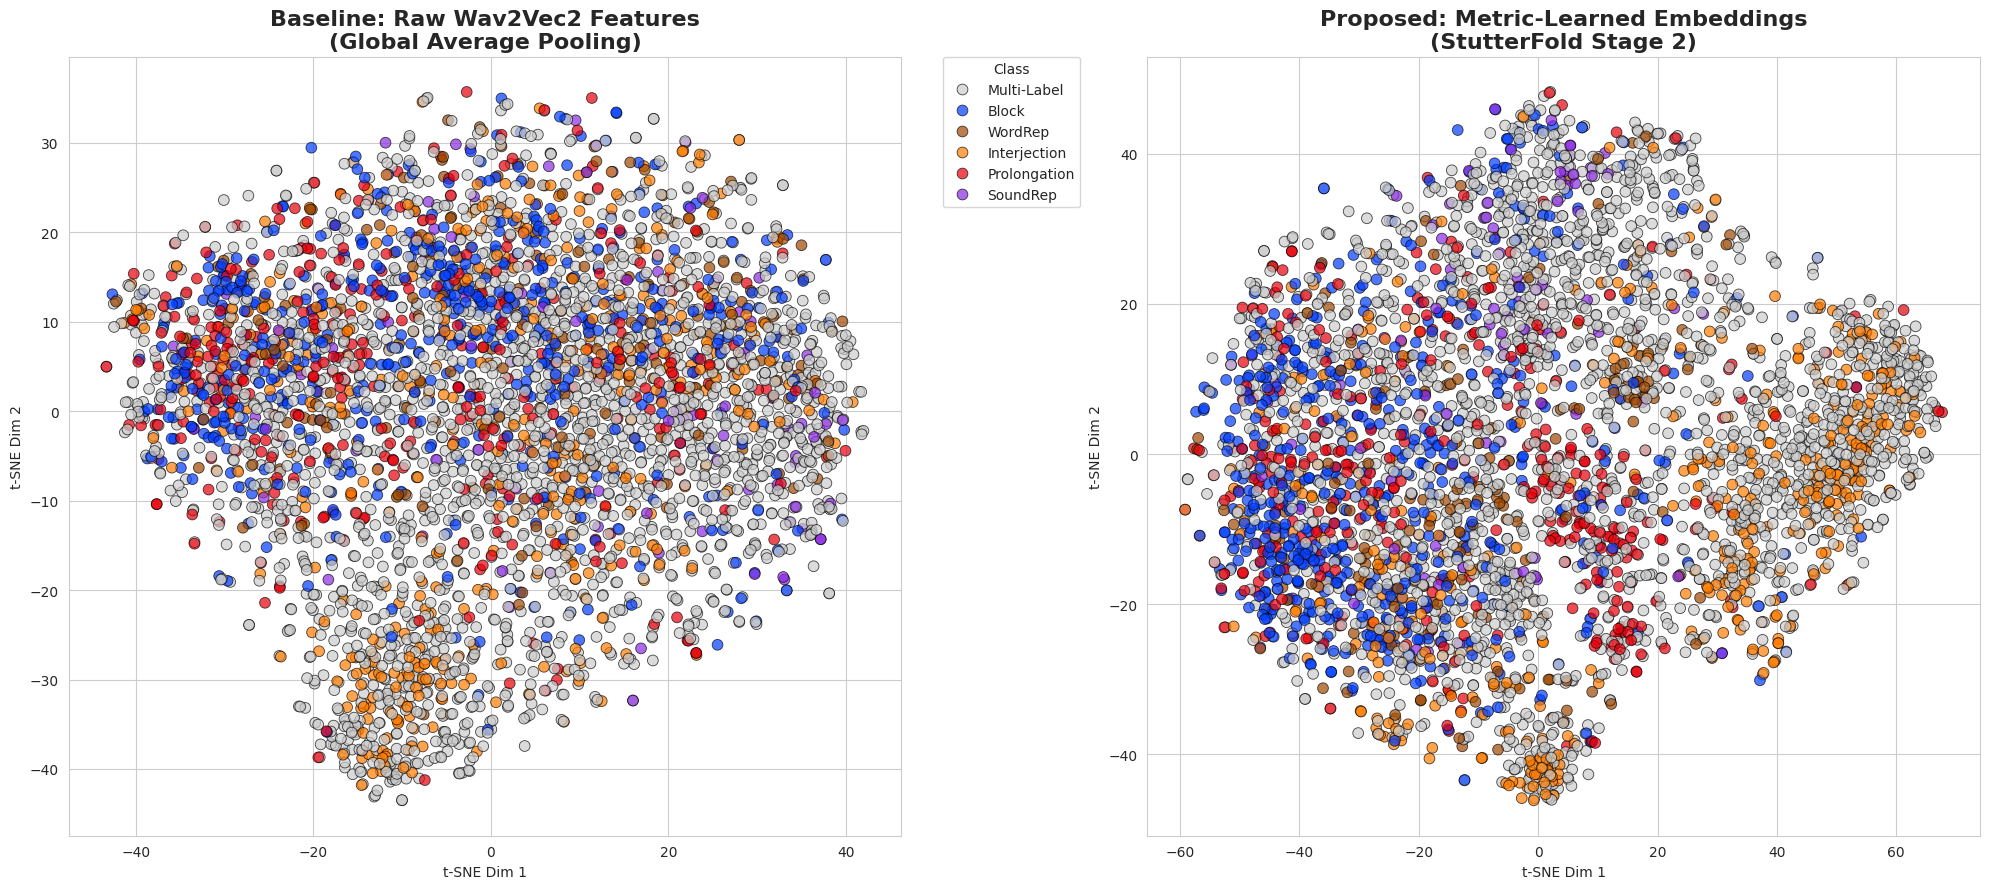

Visualization saved to: stutvec11/embedding_visualization_tsne.png


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from pathlib import Path

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 1024
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']

# t-SNE params
PERPLEXITY = 30
N_ITER = 1000
RANDOM_STATE = 42
MAX_SAMPLES = 20000

print(f"Len X_test: {len(X_test)}")
if len(X_test) > MAX_SAMPLES:
    print(f"Downsampling from {len(X_test)} to {MAX_SAMPLES} for visualization...")
    indices = np.random.choice(len(X_test), MAX_SAMPLES, replace=False)
    X_test = X_test[indices]
    y_test = y_test[indices]
embedder = embedder_model

print("Generating Baseline (Raw) Embeddings...")
X_raw_pooled = np.mean(X_test, axis=1)

X_test = X_test.astype(np.float32)
X_trained_pooled = embedder.predict(X_test, batch_size=32, verbose=1)

color_labels = []
for label_vec in y_test:
    active_indices = np.where(label_vec == 1)[0]
    if len(active_indices) == 1:
        color_labels.append(LABEL_COLS[active_indices[0]])
    elif len(active_indices) > 1:
        #mixed
        color_labels.append("Multi-Label")
    else:
        color_labels.append("Unknown")

color_labels = np.array(color_labels)

# t-sne
print("Computing t-SNE for Raw Features...")
tsne = TSNE(n_components=2, perplexity=PERPLEXITY, max_iter=N_ITER, random_state=RANDOM_STATE, init='pca', learning_rate='auto')
X_embedded_raw = tsne.fit_transform(X_raw_pooled)

print("Computing t-SNE for Trained Embeddings...")
X_embedded_trained = tsne.fit_transform(X_trained_pooled)

print("Generating Plot...")
plt.figure(figsize=(20, 9))
sns.set_style("whitegrid")

unique_labels = sorted(list(set(color_labels)))
palette = sns.color_palette("bright", len(unique_labels))
color_map = dict(zip(unique_labels, palette))
if "Multi-Label" in color_map:
    color_map["Multi-Label"] = (0.8, 0.8, 0.8)
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_embedded_raw[:, 0], y=X_embedded_raw[:, 1],
    hue=color_labels, palette=color_map, s=60, alpha=0.7, edgecolor='k'
)
plt.title("Baseline: Raw Wav2Vec2 Features\n(Global Average Pooling)", fontsize=16, weight='bold')
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_embedded_trained[:, 0], y=X_embedded_trained[:, 1],
    hue=color_labels, palette=color_map, s=60, alpha=0.7, edgecolor='k'
)
plt.title("Proposed: Metric-Learned Embeddings\n(StutterFold Stage 2)", fontsize=16, weight='bold')
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend([],[], frameon=False)

plt.tight_layout()
save_path = OUTPUT_DIR / "embedding_visualization_tsne.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"Visualization saved to: {save_path}")

Generating Interaction Map...


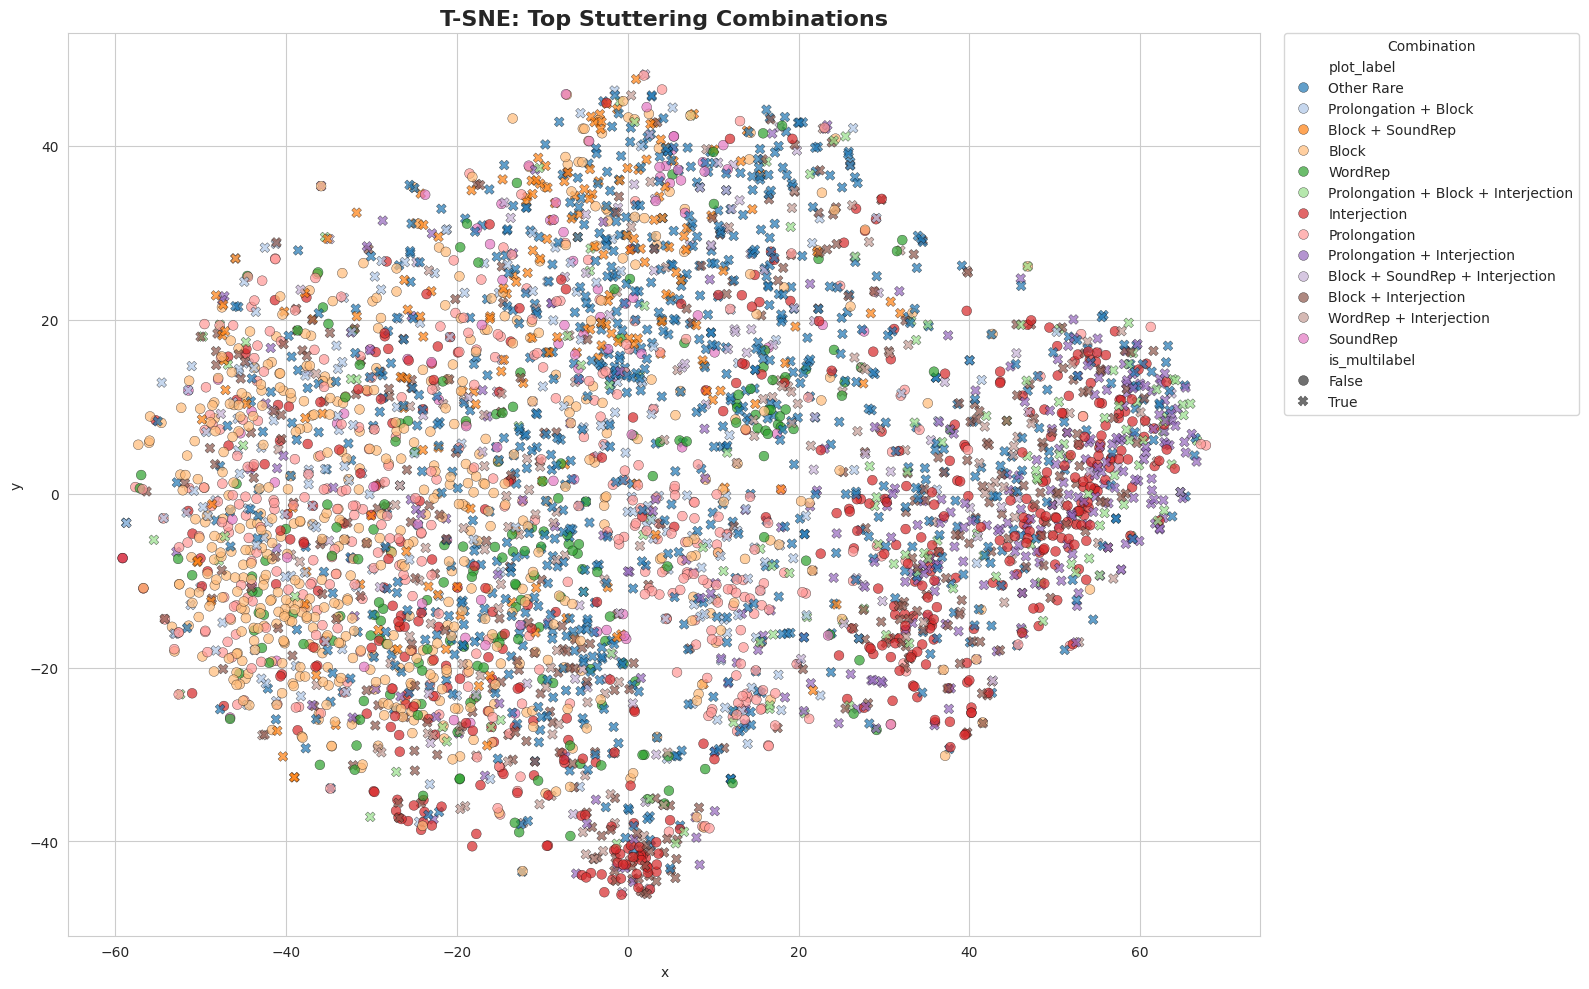

Generating Class Decomposition Grid...


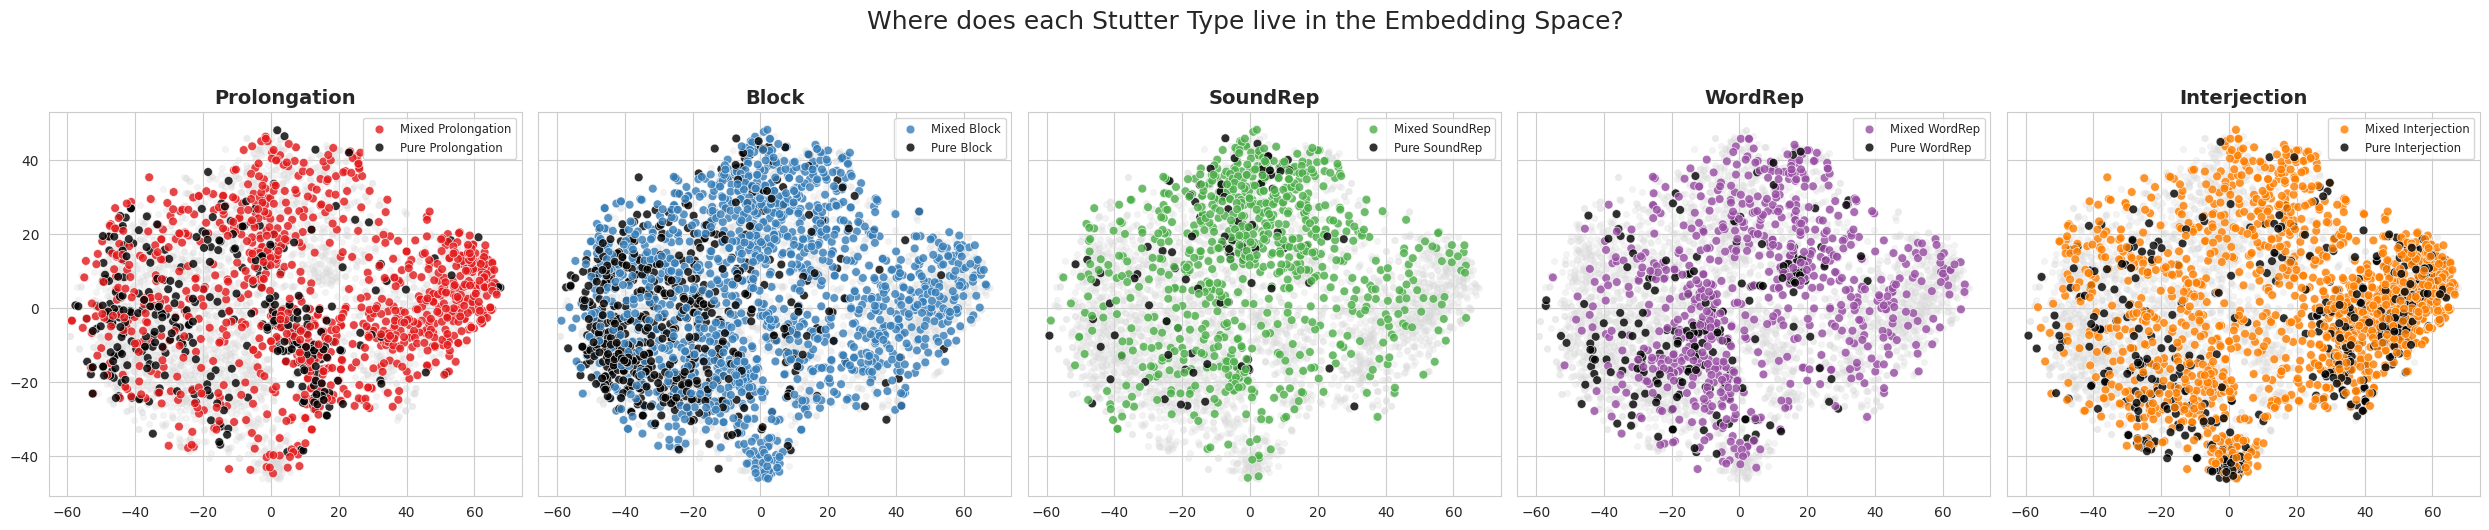

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_tsne = pd.DataFrame(X_embedded_trained, columns=['x', 'y'])

for i, label in enumerate(LABEL_COLS):
    df_tsne[label] = y_test[:, i]

def get_combo_label(row):
    active = [col for col in LABEL_COLS if row[col] == 1]
    if len(active) == 0:
        return "NoStutter"
    return " + ".join(active)

df_tsne['combination'] = df_tsne.apply(get_combo_label, axis=1)
df_tsne['is_multilabel'] = df_tsne[LABEL_COLS].sum(axis=1) > 1

print("Generating Interaction Map...")

top_combos = df_tsne['combination'].value_counts().head(12).index.tolist()

df_tsne['plot_label'] = df_tsne['combination'].apply(lambda x: x if x in top_combos else "Other Rare")

plt.figure(figsize=(16, 10))
sns.scatterplot(
    data=df_tsne, x='x', y='y',
    hue='plot_label',
    style='is_multilabel',
    palette='tab20',
    s=50, alpha=0.7, edgecolor='k', linewidth=0.3
)
plt.title("T-SNE: Top Stuttering Combinations", fontsize=16, weight='bold')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Combination")
plt.tight_layout()
plt.show()

print("Generating Class Decomposition Grid...")

fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)

bg_color = (0.85, 0.85, 0.85)

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

for i, (ax, label) in enumerate(zip(axes, LABEL_COLS)):
    sns.scatterplot(
        data=df_tsne, x='x', y='y',
        color=bg_color, s=20, alpha=0.3, ax=ax, edgecolor=None
    )

    subset = df_tsne[df_tsne[label] == 1].copy()
    subset['type'] = subset.apply(lambda x: f"Pure {label}" if x[LABEL_COLS].sum() == 1 else f"Mixed {label}", axis=1)

    sns.scatterplot(
        data=subset, x='x', y='y',
        hue='type',
        palette=[colors[i], 'black'],
        s=40, alpha=0.8, ax=ax, edgecolor='w'
    )

    ax.set_title(label, fontsize=14, weight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(loc='upper right', fontsize='small')

plt.suptitle("Where does each Stutter Type live in the Embedding Space?", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
# precomputation of vecs using embedr
print("\nGenerating Intelligent Retrieval Bank")

# tf.data.Dataset instead of raw NumPy arrays
# ,handles memory transfer to TPU without crashing the host manager
def create_predict_ds(X_data, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(X_data.astype(np.float32))
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

PREDICT_BATCH_SIZE = 512 * strategy.num_replicas_in_sync

print("Embedding Training Set...")
train_ds = create_predict_ds(X_train, PREDICT_BATCH_SIZE)
X_train_vecs = embedder_model.predict(train_ds, verbose=1)

print("Embedding Validation Set...")
val_ds = create_predict_ds(X_val, PREDICT_BATCH_SIZE)
X_val_vecs = embedder_model.predict(val_ds, verbose=1)

print("Embedding Test Set...")
test_ds = create_predict_ds(X_test, PREDICT_BATCH_SIZE)
X_test_vecs = embedder_model.predict(test_ds, verbose=1)

print(f"Embeddings generated. Train shape: {X_train_vecs.shape}")

print("\nBuilding FAISS Index")
faiss.normalize_L2(X_train_vecs) 

index = faiss.IndexFlatIP(1024)
index.add(X_train_vecs)

print("\nFinding Semantically Similar Neighbors")
def get_neighbor_vectors(query_vecs, bank_vecs, k, is_train=False):
    faiss.normalize_L2(query_vecs)
    
    search_k = k + 1 if is_train else k
    D, I = index.search(query_vecs, search_k)
    
    if is_train:
        # remv self
        I = I[:, 1:] 
        D = D[:, 1:]
        
    # retrieve the vecs from the bank
    neighbor_vectors = bank_vecs[I]
    neighbor_labels = y_train[I]
    
    return neighbor_vectors, neighbor_labels, D

print("Gathering Neighbors...")
train_n_vecs, train_n_lbls, train_n_sims = get_neighbor_vectors(X_train_vecs, X_train_vecs, K_NEIGHBORS, is_train=True)
val_n_vecs, val_n_lbls, val_n_sims = get_neighbor_vectors(X_val_vecs, X_train_vecs, K_NEIGHBORS, is_train=False)
test_n_vecs, test_n_lbls, test_n_sims = get_neighbor_vectors(X_test_vecs, X_train_vecs, K_NEIGHBORS, is_train=False)

print("\nBuilding Fast Datasets")

def spec_augment(input_seq, time_mask_param=15, freq_mask_param=25, num_masks=2):
    augmented_seq = tf.identity(input_seq)
    # freq mask
    for _ in range(num_masks):
        mask_len = tf.random.uniform([], minval=0, maxval=freq_mask_param, dtype=tf.int32)
        start = tf.random.uniform([], minval=0, maxval=EMBEDDING_DIM - mask_len, dtype=tf.int32)
        mask_start = tf.pad(tf.ones((1, start)), [[0,0], [0, EMBEDDING_DIM-start]])
        mask_end = tf.pad(tf.ones((1, start+mask_len)), [[0,0], [0, EMBEDDING_DIM-(start+mask_len)]])
        mask = 1 - (mask_end - mask_start) 
        augmented_seq = augmented_seq * mask
    # time mask
    for _ in range(num_masks):
        mask_len = tf.random.uniform([], minval=0, maxval=time_mask_param, dtype=tf.int32)
        start = tf.random.uniform([], minval=0, maxval=MAX_SEQ_LEN - mask_len, dtype=tf.int32)
        indices = tf.range(MAX_SEQ_LEN)
        mask = tf.cast((indices < start) | (indices >= start + mask_len), tf.float32)
        mask = tf.reshape(mask, (MAX_SEQ_LEN, 1))
        augmented_seq = augmented_seq * mask
    return augmented_seq

def create_dataset(X, y, n_vecs, n_lbls, n_sims, is_training=False):
    ds = tf.data.Dataset.from_tensor_slices((
        X, y, n_vecs, n_lbls, n_sims
    ))
    
    def map_func(x, y, nv, nl, ns):
        if is_training:
            do_aug = tf.random.uniform([]) < 0.7
            x = tf.cond(do_aug, lambda: spec_augment(x), lambda: x)
            
        return {
            "input_test_seq": x,
            "input_neighbor_vecs": nv,   
            "input_neighbor_labels": tf.cast(nl, tf.float32),
            "input_neighbor_sims": tf.cast(ns, tf.float32)
        }, tf.cast(y, tf.float32)

    ds = ds.map(map_func, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        ds = ds.shuffle(2048)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = create_dataset(X_train, y_train, train_n_vecs, train_n_lbls, train_n_sims, is_training=True)
val_dataset = create_dataset(X_val, y_val, val_n_vecs, val_n_lbls, val_n_sims, is_training=False)
test_dataset = create_dataset(X_test, y_test, test_n_vecs, test_n_lbls, test_n_sims, is_training=False)

print("Datasets built using INTELLIGENT EMBEDDINGS (TPU Optimized).")


 Loading Embedder 
Loading weights from stutvec11/embedder.weights.h5

 Generating Intelligent Retrieval Bank (TPU Safe) 
Embedding Training Set...


I0000 00:00:1764738253.191248      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14300291036517385206
I0000 00:00:1764738253.192912      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:8478417085741961468
I0000 00:00:1764738253.194410      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:5042991564593696160
I0000 00:00:1764738253.195906      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:12871783265679219111
I0000 00:00:1764738253.197396      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13069650227903263548
I0000 00:00:1764738253.198877      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:6392790490856165292
I0000 00:00:1764738253.200379      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:17964043314206116295
I0000 00:00:1764738253.201847      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:7093822343087220258
E0000 00:00:1764738253.46269

100/8 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ -67s 737ms/step

I0000 00:00:1764738257.311000    1195 tpu_compile_op_common.cc:245] Compilation of 5255176280933402503 with session name  took 2.044758194s and succeeded
I0000 00:00:1764738257.313730    1195 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5255176280933402503), session_name(), subgraph_key(std::string(property.function_name) = "cluster_multi_step_on_data_7_14300291036517385206", property.function_library_fingerprint = 7726525421868907075, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "139,150,1024,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1764738257.313748    1195 tpu_compilation_cache_interface.cc:542] After adding entry for key 5255176

8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 10s/step                                                                                                                                                                                                                                           
Embedding Validation Set...


I0000 00:00:1764738275.978257      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:1145710198524489078
W0000 00:00:1764738276.037313      12 loop_optimizer.cc:933] Skipping loop optimization for Merge node with control input: cond/branch_executed/_8
I0000 00:00:1764738277.242294    1139 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2675577107217581344), session_name()
I0000 00:00:1764738279.524644    1139 tpu_compile_op_common.cc:245] Compilation of 2675577107217581344 with session name  took 2.268361879s and succeeded
I0000 00:00:1764738279.526854    1139 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2675577107217581344), session_name(), subgraph_key(std::string(property.function_name) = "cluster_multi_step_on_data_1145710198524489078", property.function_library_fingerprint = 7790837377922083305, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

I0000 00:00:1764738297.764038      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:4178189581661069847
I0000 00:00:1764738297.945544    1139 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(7791270546339570816), session_name()
I0000 00:00:1764738299.319405    1139 tpu_compile_op_common.cc:245] Compilation of 7791270546339570816 with session name  took 1.373827259s and succeeded
I0000 00:00:1764738299.321853    1139 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(7791270546339570816), session_name(), subgraph_key(std::string(property.function_name) = "cluster_multi_step_on_data_4178189581661069847", property.function_library_fingerprint = 7903756995917186882, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   


 Building Vector-Based Retrieval Conformer (5-Class) 


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_test_seq      │ (None, 150, 1024) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_neighbor_vecs │ (None, 5, 1024)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_neighbor_lab… │ (None, 5, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_neighbor_sims │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conformer_e… │ (None, 1024)      │ 21,051,400 │ input_test_seq[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ neighbor_projection │ (None, 5, 1024)   │  1,049,600 │ input_neighbor_v… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedder      │ (None, 5, 16)     │         96 │ input_neighbor_l… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sim_expander        │ (None, 5, 1)      │          0 │ input_neighbor_s… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1024)   │          0 │ conformer… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ value_concatenation │ (None, 5, 1041)   │          0 │ neighbor_project… │
│ (Concatenate)       │                   │            │ label_embedder[0… │
│                     │                   │            │ sim_expander[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attention     │ (None, 1, 1024)   │  4,215,808 │ neighbor_project… │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0],    │
│                     │                   │            │ value_concatenat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1024)      │          0 │ cross_attention[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2048)      │          0 │ conformer… │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 512)       │  1,049,088 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 512)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │    131,328 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 5)         │      1,285 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,498,605 (104.90 MB)

 Trainable params: 27,490,413 (104.87 MB)

 Non-trainable params: 8,192 (32.00 KB)


 Starting Training on TPU 
Epoch 1/50


I0000 00:00:1764738396.640928      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:15196544405465854406
I0000 00:00:1764738397.592088    1147 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(8030591175030323925), session_name()
I0000 00:00:1764738430.391605    1147 tpu_compile_op_common.cc:245] Compilation of 8030591175030323925 with session name  took 32.799489443s and succeeded
I0000 00:00:1764738430.439604    1147 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(8030591175030323925), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_15196544405465854406", property.function_library_fingerprint = 11144527640593831407, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - auc_pr: 0.4675 - auc_roc: 0.6097 - binary_accuracy: 0.6457 - loss: 5.1117 - precision: 0.5170 - recall: 0.2446

I0000 00:00:1764738500.000231      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2792920178344586217
I0000 00:00:1764738500.210653    1177 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(1897399701878425158), session_name()
I0000 00:00:1764738504.962270    1177 tpu_compile_op_common.cc:245] Compilation of 1897399701878425158 with session name  took 4.751574473s and succeeded
I0000 00:00:1764738504.969984    1177 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(1897399701878425158), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_2792920178344586217", property.function_library_fingerprint = 17780453349972869333, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z 


Epoch 1: val_auc_roc improved from None to 0.72556, saving model to stutvec11/model_stfold.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 130s 369ms/step - auc_pr: 0.5556 - auc_roc: 0.6748 - binary_accuracy: 0.6759 - loss: 4.9049 - precision: 0.6025 - recall: 0.2927 - val_auc_pr: 0.6355 - val_auc_roc: 0.7256 - val_binary_accuracy: 0.6858 - val_loss: 4.5420 - val_precision: 0.6379 - val_recall: 0.4762
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - auc_pr: 0.6836 - auc_roc: 0.7759 - binary_accuracy: 0.7313 - loss: 4.3250 - precision: 0.6758 - recall: 0.5003
Epoch 2: val_auc_roc improved from 0.72556 to 0.74110, saving model to stutvec11/model_stfold.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 89s 353ms/step - auc_pr: 0.7231 - auc_roc: 0.8052 - binary_accuracy: 0.7510 - loss: 4.1351 - precision: 0.7040 - recall: 0.5324 - val_auc_pr: 0.6604 - val_auc_roc: 0.7411 - val_binary_accuracy: 0.6941 - val_loss: 3.8700 - val_precision: 0.6361 - val_recall: 0.5307
Epoch 3/50
231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 271

I0000 00:00:1764739139.008765      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9146061954640179459
E0000 00:00:1764739139.043725      12 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/cross_attention_1/attention_output_1/BiasAdd/ReadVariableOp.
I0000 00:00:1764739139.145894    1129 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(11365166293271238074), session_name()
I0000 00:00:1764739142.880577    1129 tpu_compile_op_common.cc:245] Compilation of 11365166293271238074 with session name  took 3.734653735s and succeeded
I0000 00:00:1764739142.886139    1129 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(11365166293271238074), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_9146061954640179459", property.function_library_fingerprint = 16512439221032829175, p

30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 320ms/step

 Classification Report (5 Stuttering Classes) 
              precision    recall  f1-score   support

Prolongation       0.47      0.81      0.59      1335
       Block       0.53      0.89      0.67      1982
    SoundRep       0.39      0.74      0.51       886
     WordRep       0.44      0.73      0.54       917
Interjection       0.66      0.84      0.74      1833

   micro avg       0.51      0.82      0.63      6953
   macro avg       0.50      0.80      0.61      6953
weighted avg       0.52      0.82      0.64      6953
 samples avg       0.53      0.84      0.61      6953


 Generating plots for model training history... 


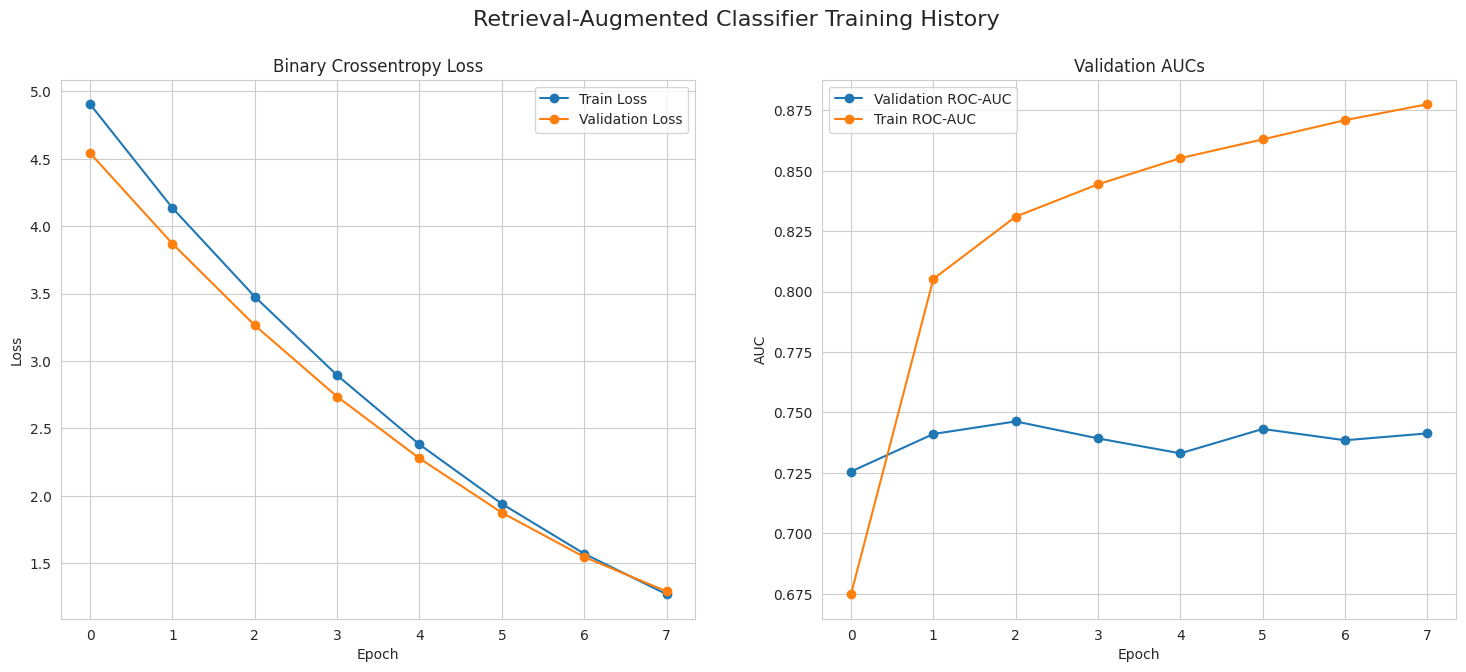


 Full pipeline complete. 


In [ ]:
# RETRIEVAL-AUGMENTED CONFORMER
def conformer_block(x, num_heads=4, ff_dim=128, dropout=0.1): 
    # conv module
    x_conv = layers.LayerNormalization()(x)
    x_conv = layers.Conv1D(filters=EMBEDDING_DIM * 2, kernel_size=1, activation="relu")(x_conv)
    x_conv = layers.DepthwiseConv1D(kernel_size=3, padding="same")(x_conv)
    x_conv = layers.BatchNormalization()(x_conv)
    x_conv = layers.Activation("swish")(x_conv)
    x_conv = layers.Conv1D(filters=EMBEDDING_DIM, kernel_size=1, kernel_regularizer=regularizers.l1(5e-5))(x_conv)
    x_conv = layers.Dropout(dropout)(x_conv)
    x = x + x_conv

    # attn module
    x_attn = layers.LayerNormalization()(x)
    x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
    x_attn = layers.Dropout(dropout)(x_attn)
    x = x + x_attn

    # ffn
    x_ff = layers.LayerNormalization()(x)
    x_ff = layers.Dense(ff_dim, activation="swish")(x_ff)
    x_ff = layers.Dropout(dropout)(x_ff)
    x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
    x = x + x_ff
    return x

with strategy.scope():
    print("\nBuilding Vector-Based Retrieval Conformer (5-Class)")

    # main clip is seq (time x dimn)
    input_test_seq = layers.Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), name="input_test_seq")
    
    # neighbor vecs (k x dimn)
    input_neighbor_vecs = layers.Input(shape=(K_NEIGHBORS, EMBEDDING_DIM), name="input_neighbor_vecs")
    input_neighbor_labels = layers.Input(shape=(K_NEIGHBORS, NUM_CLASSES), name="input_neighbor_labels")
    input_neighbor_sims = layers.Input(shape=(K_NEIGHBORS,), name="input_neighbor_sims")

    # QUERY ENCODER, the main clip goes through the heavy Conformer
    encoder_input = layers.Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), name="encoder_input")
    x = conformer_block(encoder_input, num_heads=4, ff_dim=1028, dropout=0.5)
    x = conformer_block(x, num_heads=4, ff_dim=1028, dropout=0.5)
    # pool -> (Batch, 1024)
    encoder_output = layers.GlobalAveragePooling1D()(x) 
    
    encoder = tf.keras.Model(inputs=encoder_input, outputs=encoder_output, name="conformer_encoder")

    # query vec
    q_test = encoder(input_test_seq) # Shape: (Batch, 1024)

    # projection layer, allows model to adapt fixed vecs for curr task.
    k_neighbors = layers.Dense(1024, activation='relu', name="neighbor_projection")(input_neighbor_vecs)

    # val
    # Comb, Neighbor Features + Labels + Similarity Scores
    processed_labels = layers.Dense(16, activation='relu', name="label_embedder")(input_neighbor_labels)
    processed_sims = layers.Reshape((K_NEIGHBORS, 1), name="sim_expander")(input_neighbor_sims)
    
    v_neighbors = layers.Concatenate(name="value_concatenation")([
        k_neighbors,
        processed_labels,
        processed_sims
    ])

    # CROSS ATTN
    # Query = main clip vec, reshp for attn
    query_for_attention = layers.Reshape((1, 1024))(q_test)

    attention_output = layers.MultiHeadAttention(
        num_heads=4, key_dim=256, name="cross_attention"
    )(query=query_for_attention, key=k_neighbors, value=v_neighbors)
    
    context_vector = layers.Reshape((attention_output.shape[-1],))(attention_output)

    # FINAL CLASSIFIER
    final_representation = layers.Concatenate()([q_test, context_vector])
    
    x = layers.Dense(512, activation='relu')(final_representation)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(256, activation='relu')(x)
    
    outputs = layers.Dense(NUM_CLASSES, activation='sigmoid', name="output")(x)

    model = tf.keras.Model(
        inputs={
            "input_test_seq": input_test_seq,
            "input_neighbor_vecs": input_neighbor_vecs, # Note the Key Change here
            "input_neighbor_labels": input_neighbor_labels,
            "input_neighbor_sims": input_neighbor_sims
        },
        outputs=outputs
    )

    optimizer = tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=5e-4)
    
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=[
            'binary_accuracy', 
            tf.keras.metrics.Precision(name='precision'), 
            tf.keras.metrics.Recall(name='recall'), 
            tf.keras.metrics.AUC(name='auc_roc'), 
            tf.keras.metrics.AUC(curve='PR', name='auc_pr')
        ]
    )

model.summary()

print("\n Starting Training on TPU ")

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc_roc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', mode='max', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


print("\n Evaluating Model on the Test Set ")

# model.load_weights(BEST_MODEL_PATH)

y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions * BATCH_SIZE]

y_test_eval_list = []
for _, labels in test_dataset.unbatch().as_numpy_iterator():
    y_test_eval_list.append(labels)
y_test_eval = np.array(y_test_eval_list)

print("\n Classification Report (5 Stuttering Classes) ")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report_retrieval.txt", "w") as f:
    f.write(report)

print("\n Generating plots for model training history... ")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Retrieval-Augmented Classifier Training History', fontsize=16)

ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

ax2.plot(history_dict['val_auc_roc'], 'o-', label='Validation ROC-AUC')
ax2.plot(history_dict['auc_roc'], 'o-', label='Train ROC-AUC')
ax2.set_title('Validation AUCs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)

plt.savefig(OUTPUT_DIR / "training_history_retrieval.png")
plt.show()

print("\npipeline complete.")


## essemble gated fusion

In [ ]:
# EXPERT A: PURE AUDIO CONFORMER
# Conformer Block
def conformer_block_audio(x, num_heads=4, ff_dim=128, dropout=0.1): 
    x_conv = layers.LayerNormalization()(x)
    x_conv = layers.Conv1D(filters=EMBEDDING_DIM * 2, kernel_size=1, activation="relu")(x_conv)
    x_conv = layers.DepthwiseConv1D(kernel_size=3, padding="same")(x_conv)
    x_conv = layers.BatchNormalization()(x_conv)
    x_conv = layers.Activation("swish")(x_conv)
    x_conv = layers.Conv1D(filters=EMBEDDING_DIM, kernel_size=1, kernel_regularizer=regularizers.l1(5e-5))(x_conv)
    x_conv = layers.Dropout(dropout)(x_conv)
    x = x + x_conv

    x_attn = layers.LayerNormalization()(x)
    x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
    x_attn = layers.Dropout(dropout)(x_attn)
    x = x + x_attn

    x_ff = layers.LayerNormalization()(x)
    x_ff = layers.Dense(ff_dim, activation="swish")(x_ff)
    x_ff = layers.Dropout(dropout)(x_ff)
    x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
    x = x + x_ff
    return x

with strategy.scope():
    print("\n Building Expert A (Pure Audio) ")
    input_seq = layers.Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), name="input_audio")
    
    # regu
    x = layers.SpatialDropout1D(0.2)(input_seq)
    x = layers.GaussianNoise(0.1)(x)
    
    # Conformer Encoder
    x = conformer_block_audio(x, num_heads=4, ff_dim=512, dropout=0.3)
    x = conformer_block_audio(x, num_heads=4, ff_dim=512, dropout=0.3)
    
    # name the layer for extraction for fusion
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu', name="audio_features")(x)
    x = layers.Dropout(0.4)(x)
    
    output = layers.Dense(NUM_CLASSES, activation='sigmoid', name="audio_output")(x)
    
    model_a = tf.keras.Model(inputs=input_seq, outputs=output, name="Expert_A")
    
    model_a.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-2),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc_roc')]
    )
model_a.summary()
def create_audio_ds(X, y, is_train=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if is_train:
        ds = ds.shuffle(2048)
        ds = ds.map(lambda x, y: (spec_augment(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print("Training Expert A...")
history_a = model_a.fit(
    create_audio_ds(X_train, y_train, True),
    validation_data=create_audio_ds(X_val, y_val, False),
    epochs=30,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("model_expert_a.keras", save_best_only=True, monitor='val_auc_roc', verbose = 1)]
)


 Building Expert A (Pure Audio) 


Model: "Expert_A"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_audio         │ (None, 150, 1024) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 150, 1024) │          0 │ input_audio[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 150, 1024) │          0 │ spatial_dropout1… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 1024) │      2,048 │ gaussian_noise_1… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 150, 2048) │  2,099,200 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv1d_4  │ (None, 150, 2048) │      8,192 │ conv1d_8[0][0]    │
│ (DepthwiseConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 2048) │      8,192 │ depthwise_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 150, 2048) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 150, 1024) │  2,098,176 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 150, 1024) │          0 │ conv1d_9[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 150, 1024) │          0 │ gaussian_noise_1… │
│                     │                   │            │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 1024) │      2,048 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 150, 1024) │  4,198,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 150, 1024) │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 150, 1024) │          0 │ add_12[0][0],     │
│                     │                   │            │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 150, 1024) │      2,048 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 150, 512)  │    524,800 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 150, 512)  │          0 │ dense_20[0][0]  

 Total params: 19,200,517 (73.24 MB)

 Trainable params: 19,192,325 (73.21 MB)

 Non-trainable params: 8,192 (32.00 KB)

Training Expert A...
Epoch 1/30


I0000 00:00:1764740229.398193      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:15005332209426266973
I0000 00:00:1764740230.134011    1133 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16465005047374261980), session_name()
I0000 00:00:1764740261.172413    1133 tpu_compile_op_common.cc:245] Compilation of 16465005047374261980 with session name  took 31.038363466s and succeeded
I0000 00:00:1764740261.211437    1133 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16465005047374261980), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_15005332209426266973", property.function_library_fingerprint = 386675203889917719, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap(

231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - auc_roc: 0.6262 - loss: 3.6935

I0000 00:00:1764740344.292694      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2515471235186410566
I0000 00:00:1764740344.432349    1204 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3299759575082021515), session_name()
I0000 00:00:1764740348.791293    1204 tpu_compile_op_common.cc:245] Compilation of 3299759575082021515 with session name  took 4.35890178s and succeeded
I0000 00:00:1764740348.798644    1204 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3299759575082021515), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_2515471235186410566", property.function_library_fingerprint = 11977935601037336836, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z =


Epoch 1: val_auc_roc improved from None to 0.65329, saving model to model_expert_a.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 141s 428ms/step - auc_roc: 0.6508 - loss: 2.4378 - val_auc_roc: 0.6533 - val_loss: 0.9620
Epoch 2/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - auc_roc: 0.6817 - loss: 0.8263
Epoch 2: val_auc_roc improved from 0.65329 to 0.65703, saving model to model_expert_a.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 98s 389ms/step - auc_roc: 0.6951 - loss: 0.7567 - val_auc_roc: 0.6570 - val_loss: 0.7360
Epoch 3/30
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - auc_roc: 0.7013 - loss: 0.6913
Epoch 3: val_auc_roc improved from 0.65703 to 0.70386, saving model to model_expert_a.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 106s 426ms/step - auc_roc: 0.7081 - loss: 0.6892 - val_auc_roc: 0.7039 - val_loss: 0.7445
Epoch 4/30
231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - auc_roc: 0.7033 - loss: 0.7195
Epoch 4: val_auc_roc improved from 0.70386 to 0.72721, saving model to model_expert_a.keras
232/232 ━━━━━━━━━

In [ ]:
# Model B: NEURAL RETRIEVAL EXPERT
def build_retrieval_expert():
    input_vecs = layers.Input(shape=(K_NEIGHBORS, EMBEDDING_DIM), name="input_vecs")
    
    # projc neighbs (1024 -> 256)
    x = layers.Dense(256, activation='swish')(input_vecs) 
    
    # aggregation (avg poolg)
    # Collapse k neighbs -> 1 summary vec (Batch, 256)
    x = layers.GlobalAveragePooling1D()(x) 
    
    x = layers.Dense(256, activation='swish')(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(128, activation='swish', name="retrieval_features")(x) 
    
    output = layers.Dense(NUM_CLASSES, activation='sigmoid', name="retrieval_output")(x)
    
    return tf.keras.Model(inputs=input_vecs, outputs=output, name="Expert_B")

def make_vec_ds(vecs, y, is_train=False):
    ds = tf.data.Dataset.from_tensor_slices((vecs, y))
    
    if is_train: 
        ds = ds.shuffle(2048)
        
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

with strategy.scope():
    expert_b = build_retrieval_expert()
    expert_b.compile(
        optimizer=tf.keras.optimizers.AdamW(1e-3), 
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc_roc')]
    )

print("Training Expert B (Neural Retrieval)...")
history_B = expert_b.fit(
    make_vec_ds(train_n_vecs, y_train, True),
    validation_data=make_vec_ds(val_n_vecs, y_val, False),
    epochs=30,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint("expert_b.keras", save_best_only=True, monitor='val_auc_roc', verbose=1)
    ]
)

Training Expert B (Neural Retrieval)...
Epoch 1/30


I0000 00:00:1764739568.254961      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:15442904198237903753
I0000 00:00:1764739568.389050    1190 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(8265938462450944896), session_name()


  7/232 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - auc_roc: 0.5271 - loss: 0.6863

I0000 00:00:1764739570.706138    1190 tpu_compile_op_common.cc:245] Compilation of 8265938462450944896 with session name  took 2.316994994s and succeeded
I0000 00:00:1764739570.711728    1190 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(8265938462450944896), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_15442904198237903753", property.function_library_fingerprint = 4302732131177079270, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1764739570.711753    1190 tpu_compilation_cache_interface.cc:542] After adding entry for key 8265938462450944896 with 

231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc_roc: 0.7191 - loss: 0.5702

I0000 00:00:1764739576.314211      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14510776670553735154
I0000 00:00:1764739576.366279    1127 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16411971056339587425), session_name()
I0000 00:00:1764739576.875635    1127 tpu_compile_op_common.cc:245] Compilation of 16411971056339587425 with session name  took 509.313128ms and succeeded
I0000 00:00:1764739576.877567    1127 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16411971056339587425), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_14510776670553735154", property.function_library_fingerprint = 8337533639021560337, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap(


Epoch 1: val_auc_roc improved from None to 0.74941, saving model to expert_b.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - auc_roc: 0.7921 - loss: 0.5139 - val_auc_roc: 0.7494 - val_loss: 0.5836
Epoch 2/30
231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc_roc: 0.8261 - loss: 0.4798
Epoch 2: val_auc_roc did not improve from 0.74941
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - auc_roc: 0.8337 - loss: 0.4697 - val_auc_roc: 0.7413 - val_loss: 0.5942
Epoch 3/30
230/232 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - auc_roc: 0.8445 - loss: 0.4557
Epoch 3: val_auc_roc did not improve from 0.74941
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - auc_roc: 0.8404 - loss: 0.4614 - val_auc_roc: 0.7479 - val_loss: 0.5890
Epoch 4/30
231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc_roc: 0.8404 - loss: 0.4646
Epoch 4: val_auc_roc did not improve from 0.74941
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - auc_roc: 0.8444 - loss: 0.4566 - val_auc_roc: 0.7492 - val_loss: 0.5895
Epoch 5/30
231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# FUSION MODEL: LEARNABLE GATING
with strategy.scope():
    print("\n Building Fusion Model ")
    
    # Experts
    expert_a = tf.keras.models.load_model("model_expert_a.keras")
    expert_b = tf.keras.models.load_model("expert_b.keras")
    
    expert_a.trainable = False
    expert_b.trainable = False
    
    # inp
    in_audio = layers.Input(shape=(MAX_SEQ_LEN, EMBEDDING_DIM), name="input_audio")
    in_vecs = layers.Input(shape=(K_NEIGHBORS, EMBEDDING_DIM), name="input_vecs")
    
    # extract feats 
    feat_a = expert_a.get_layer("audio_features").output
    model_feat_a = tf.keras.Model(expert_a.input, feat_a)
    out_a = model_feat_a(in_audio) # (Batch, 256)
    
    feat_b = expert_b.get_layer("retrieval_features").output
    model_feat_b = tf.keras.Model(expert_b.input, feat_b)
    out_b = model_feat_b(in_vecs) # (Batch, 128)
    
    # gated fusion
    combined = layers.Concatenate()([out_a, out_b])
    
    # Gate (0 = Audio, 1 = Retrieval)
    gate = layers.Dense(128, activation='sigmoid', name="trust_gate")(combined)
    
    # scale retrieval feats by gate
    gated_retrieval = layers.Multiply()([out_b, gate])
    
    # combine
    fused = layers.Concatenate()([out_a, gated_retrieval])
    
    # final head
    x = layers.Dense(128, activation='relu')(fused)
    x = layers.Dropout(0.4)(x)
    final_out = layers.Dense(NUM_CLASSES, activation='sigmoid', name="final_output")(x)
    
    fusion_model = tf.keras.Model(
        inputs=[in_audio, in_vecs],
        outputs=final_out,
        name="Fusion_System"
    )
    
    fusion_model.compile(
        optimizer=tf.keras.optimizers.AdamW(1e-3),
        loss='binary_crossentropy',
        metrics=[
            'binary_accuracy', 
            tf.keras.metrics.AUC(name='auc_roc'), 
            tf.keras.metrics.AUC(curve='PR', name='auc_pr')
        ]
    )

def create_fusion_ds(X, vecs, y, is_train=False):
    ds = tf.data.Dataset.from_tensor_slices((
        {"input_audio": X, "input_vecs": vecs}, 
        y
    ))
    if is_train:
        ds = ds.shuffle(2048)
        ds = ds.map(lambda i, l: ({"input_audio": spec_augment(i["input_audio"]), "input_vecs": i["input_vecs"]}, l), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print("Training Fusion Model...")
history_f = fusion_model.fit(
    create_fusion_ds(X_train, train_n_vecs, y_train, True),
    validation_data=create_fusion_ds(X_val, val_n_vecs, y_val, False),
    epochs=20,
    callbacks=[tf.keras.callbacks.ModelCheckpoint("model_fusion_final.keras", save_best_only=True, monitor='val_auc_roc', mode='max', verbose = 1)]
)


 Building Fusion Model 
Training Fusion Model...
Epoch 1/20


I0000 00:00:1764743890.063983      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:6863198509092664430
I0000 00:00:1764743890.488838    1131 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(4799662857656440827), session_name()


  1/232 ━━━━━━━━━━━━━━━━━━━━ 2:04:14 32s/step - auc_pr: 0.5384 - auc_roc: 0.5657 - binary_accuracy: 0.5250 - loss: 0.7703

I0000 00:00:1764743913.571849    1131 tpu_compile_op_common.cc:245] Compilation of 4799662857656440827 with session name  took 23.082917909s and succeeded
I0000 00:00:1764743913.604794    1131 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(4799662857656440827), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_6863198509092664430", property.function_library_fingerprint = 7472061169345320861, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1764743913.604821    1131 tpu_compilation_cache_interface.cc:542] After adding entry for key 4799662857656440827 with 

232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - auc_pr: 0.6972 - auc_roc: 0.7827 - binary_accuracy: 0.7273 - loss: 0.5290

I0000 00:00:1764744002.360993      12 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:15573930384134002272
I0000 00:00:1764744002.540080    1123 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(406193933005417390), session_name()
I0000 00:00:1764744007.137046    1123 tpu_compile_op_common.cc:245] Compilation of 406193933005417390 with session name  took 4.596928016s and succeeded
I0000 00:00:1764744007.144179    1123 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(406193933005417390), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_15573930384134002272", property.function_library_fingerprint = 12257853950148433587, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 4, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z =


Epoch 1: val_auc_roc improved from None to 0.76348, saving model to model_fusion_final.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 137s 453ms/step - auc_pr: 0.7595 - auc_roc: 0.8313 - binary_accuracy: 0.7683 - loss: 0.4729 - val_auc_pr: 0.6971 - val_auc_roc: 0.7635 - val_binary_accuracy: 0.7121 - val_loss: 0.5870
Epoch 2/20
231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - auc_pr: 0.7833 - auc_roc: 0.8506 - binary_accuracy: 0.7801 - loss: 0.4474
Epoch 2: val_auc_roc did not improve from 0.76348
232/232 ━━━━━━━━━━━━━━━━━━━━ 110s 444ms/step - auc_pr: 0.7909 - auc_roc: 0.8556 - binary_accuracy: 0.7880 - loss: 0.4424 - val_auc_pr: 0.6916 - val_auc_roc: 0.7585 - val_binary_accuracy: 0.7099 - val_loss: 0.5937
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - auc_pr: 0.7803 - auc_roc: 0.8535 - binary_accuracy: 0.7844 - loss: 0.4485
Epoch 3: val_auc_roc did not improve from 0.76348
232/232 ━━━━━━━━━━━━━━━━━━━━ 119s 479ms/step - auc_pr: 0.7956 - auc_roc: 0.8594 - binary_accuracy: 0.7911 - loss: 0.4371

In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n Preparing Test Data (Aligned) ")
BATCH_SIZE = 128 

def create_test_audio_ds(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    return ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

def create_test_vec_ds(vecs, y):
    ds = tf.data.Dataset.from_tensor_slices((vecs, y))
    return ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

def create_test_fusion_ds(X_aud, X_vecs, y):
    ds = tf.data.Dataset.from_tensor_slices(({"input_audio": X_aud, "input_vecs": X_vecs}, y))
    return ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

ds_test_A = create_test_audio_ds(X_test, y_test)
ds_test_B = create_test_vec_ds(test_n_vecs, y_test)
ds_test_Fusion = create_test_fusion_ds(X_test, test_n_vecs, y_test)

print("\n Loading Models & Predicting ")

print("Predicting Expert A (Audio)...")
expert_a = tf.keras.models.load_model("model_expert_a.keras") 
pred_a = expert_a.predict(ds_test_A, verbose=1)

print("Predicting Fusion Model...")
fusion_model = tf.keras.models.load_model("model_fusion_final.keras")
pred_fusion = fusion_model.predict(ds_test_Fusion, verbose=1)

y_test_aligned = y_test[:len(pred_fusion)]

def get_best_f1(y_true, y_pred):
    # grid search for best Micro F1
    best_t = 0.5
    best_f1 = 0.0
    for t in np.arange(0.1, 0.9, 0.05):
        f1 = f1_score(y_true, (y_pred >= t).astype(int), average='micro')
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t

thresh_a = get_best_f1(y_test_aligned, pred_a)
thresh_f = get_best_f1(y_test_aligned, pred_fusion)

print(f"\nOptimal Thresholds Found: Fusion={thresh_f:.2f}")
def print_report(name, y_true, y_pred, thresh):
    print(f"\n {name} Results ")
    print(classification_report(y_true, (y_pred >= thresh).astype(int), target_names=LABEL_COLS, zero_division=0))

print_report("Expert A (Audio)", y_test_aligned, pred_a, 0.45)
print_report("FUSION MODEL", y_test_aligned, pred_fusion, thresh_f)

f1_scores = {
    'Class': LABEL_COLS,
    'Audio (A)': f1_score(y_test_aligned, (pred_a >= thresh_a).astype(int), average=None),
    'Fusion': f1_score(y_test_aligned, (pred_fusion >= thresh_f).astype(int), average=None)
}

df_scores = pd.DataFrame(f1_scores)
df_scores['Gain vs Audio'] = df_scores['Fusion'] - df_scores['Audio (A)']

print("\n FUSION IMPACT ANALYSIS ")
print(df_scores[['Class', 'Audio (A)', 'Fusion', 'Gain vs Audio']].round(3))


 Preparing Test Data (Aligned) 

 Loading Models & Predicting 
Predicting Expert A (Audio)...
30/30 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step
Predicting Expert B (Retrieval)...
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicting Fusion Model...


/usr/local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 46 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


30/30 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step

Optimal Thresholds Found: Fusion=0.35

 Expert A (Audio) Results 
              precision    recall  f1-score   support

Prolongation       0.65      0.50      0.56      1252
       Block       0.62      0.49      0.54      1982
    SoundRep       0.49      0.56      0.52       886
     WordRep       0.48      0.65      0.55       917
Interjection       0.87      0.66      0.75      1833

   micro avg       0.63      0.56      0.60      6953
   macro avg       0.62      0.57      0.59      6953
weighted avg       0.66      0.56      0.60      6953
 samples avg       0.61      0.58      0.56      6953


 FUSION MODEL Results 
              precision    recall  f1-score   support

Prolongation       0.53      0.73      0.61      1335
       Block       0.58      0.76      0.66      1982
    SoundRep       0.49      0.59      0.54       886
     WordRep       0.50      0.62      0.55       917
Interjection       0.76      0.78      0.77      1833

 